In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from astropy.constants import m_p, M_sun
from scipy.ndimage import uniform_filter1d
from scipy.integrate import simps
import astropy.units as u
from plotting_setup import *


sys.path.append('../pipeline_scripts/')
from pipeline_main_nosink import pipeline_nosink
from pipeline_2D_nosink import to_osyris_ivs
from pipeline_main import sink_positions, serialize_dictionary, sinks, true_sinks, pipeline, calc_ang
from pipeline_1D import to_1D


core_data = {}
initial_sn = [302, 350, 223, 260, 287, 383, 410, 439, 449]
first_sink_snap = [159, 223, 177, 213, 236, 342, 402, 404, 446]

In [4]:
plot_data = serialize_dictionary(filename = 'fmr05AM_evolution2.pkl', store = False)

In [5]:
data = pipeline(snap = 362, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:18<00:00, 228.19it/s]


In [6]:
data.to_1D(plot = False, r_in= 5, r_out = 200, Nr = 200, verbose = 0)

100%|██████████| 199/199 [00:05<00:00, 37.27it/s]


In [7]:
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:01<00:00, 2998.71it/s]


In [10]:
np.sum(data.L**2)**0.5

0.9999999999999999

In [9]:
np.cross(np.array([0,1,0]), np.array([0,0,1]))

array([1, 0, 0])

In [30]:
disk_size = {sink: np.zeros_like(plot_data[sink]['time']) for sink in sinks}

In [19]:
plot_data[122].keys()

dict_keys(['v_φ', 'v_kep', 'Σ', 'H', 'orientation', 'time'])

In [42]:
for i, sink in enumerate(sinks):
    for j in range(len(plot_data[sink]['time'])):
        if plot_data[sink]['time'][j] == 0: 
            disk_size[sink][j] = np.nan
            continue
        kep_vel = plot_data[sink]['v_kep'][j]
        v_φ = plot_data[sink]['v_φ'][j]
        orbitvel_ratio_mean = uniform_filter1d(v_φ / kep_vel, size = 10)
        for k in range(len(v_φ)):
            if orbitvel_ratio_mean[k] < 0.8:
                disk_size[sink][j] = data.r_1D[k] * data.au_length
                break
        
        

In [90]:
disk_mass = {sink: np.zeros_like(plot_data[sink]['time']) for sink in sinks}

In [91]:
r = data.r_1D * data.sn.scaling.l
for i, sink in enumerate(sinks):
    for j in range(len(plot_data[sink]['time'])):
        if plot_data[sink]['time'][j] == 0 or disk_size[sink][j] == 0: 
            disk_mass[sink][j] = np.nan
            continue
        Σ = plot_data[sink]['Σ'][j]
        cut = np.argmin(abs(r / data.sn.cgs.au - disk_size[sink][j]))
        if cut == 0: 
            disk_mass[sink][j] = np.nan
            continue
        disk_mass[sink][j] = simps(2 * np.pi * Σ[:cut] * r[:cut], r[:cut]) / data.sn.cgs.m_sun

In [15]:
orientation = {sink: np.rad2deg(np.arccos(np.sum(plot_data[sink]['orientation'] * plot_data[sink]['orientation'][None,-1], axis = 1))) for sink in sinks}
### timesteps with no orientation gives angles of 90 degrees and the final output is a nan-value. This is changed in the loop below ###
for sink in sinks:
    orientation[sink][-1] = 0
    orientation[sink][orientation[sink] == 90.] = np.nan
    

/tmp/ipykernel_2498973/2301774758.py:1: RuntimeWarning: invalid value encountered in arccos
  orienation = {sink: np.rad2deg(np.arccos(np.sum(plot_data[sink]['orientation'] * plot_data[sink]['orientation'][None,-1], axis = 1))) for sink in sinks}


In [93]:
AM_evo = {sink: np.zeros_like(plot_data[sink]['time']) for sink in sinks}

In [94]:
for i, sink in enumerate(sinks):
    for j in range(len(plot_data[sink]['time'])):
        if plot_data[sink]['time'][j] == 0: 
            AM_evo[sink][j] = np.nan
            continue
        kep_vel = plot_data[sink]['v_kep'][j]
        v_φ = plot_data[sink]['v_φ'][j]
        L_tot = simps(2 * np.pi * Σ * v_φ * r**2, r)
        L_kep = simps(2 * np.pi * Σ * kep_vel * r**2, r)  
        AM_evo[sink][j] = L_tot / L_kep

No handles with labels found to put in legend.


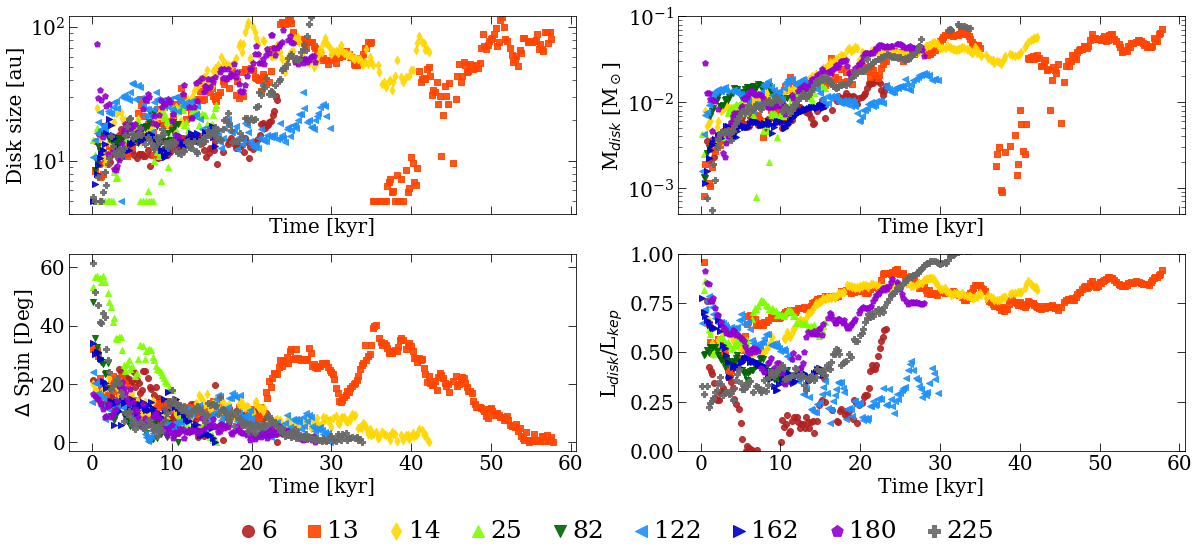

In [101]:

markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', 'P']

fig, axs = plt.subplots(2,2, figsize = (20, 8), sharex=True)

axs.flatten()[0].set(ylabel = 'Disk size [au]', ylim = (4, 120))
axs.flatten()[1].set(ylabel = 'M$_{disk}$ [M$_\odot$]',ylim = (5e-4, 0.1))
axs.flatten()[2].set(ylabel = '$\Delta$ Spin [Deg]')
axs.flatten()[3].set(ylabel = 'L$_{disk}$/L$_{kep}$', ylim = (0,1))


[ax.set_yscale('log') for ax in axs.flatten()[:2]]
    
for param, ax in zip([disk_size, disk_mass, orientation, AM_evo] , axs.flatten()):
    for i, sink in enumerate(sinks):
        ax.set(xlabel = 'Time [kyr]')
        ax.scatter(plot_data[sink]['time'] * 1e-3, param[sink], marker = markers[i], label = sink, color = sink_colors[i], alpha = 0.9)
        #ax.legend(frameon = False, ncol = 2, prop = {'size':14})

cbaxes = fig.add_axes([0.1, 0.02, 0.8, 0.05])
handles, labels = axs[0, 0].get_legend_handles_labels()
cbaxes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
cbaxes.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, 0.5), frameon = False, ncol=9, prop = {'size':25}, columnspacing=0.5, handletextpad=-0.5, markerscale  = 2)
cbaxes.axis('off')

fig.savefig(save_folder + 'gendisk_evolution', facecolor = 'w', bbox_inches='tight', dpi = 500)


In [99]:
for i, sink in enumerate(sinks):
    print(f'Final disk mass {disk_mass[sink][-1]:1.3f}')



Final disk mass 0.016
Final disk mass 0.071
Final disk mass 0.058
Final disk mass 0.015
Final disk mass 0.011
Final disk mass 0.018
Final disk mass 0.008
Final disk mass 0.035
Final disk mass 0.074


# Calculating φ and θ for sink 13, in resp. to x-axis

[nan, nan, nan]

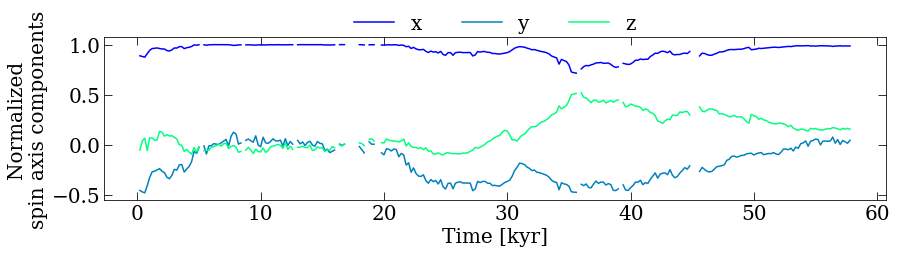

In [89]:

x = np.zeros_like(plot_data[13]['time']); y = np.zeros_like(x); z = np.zeros_like(y)
L = plot_data[13]['orientation']

colors = plt.cm.winter(np.linspace(0,1, 3))

for i in range(len(plot_data[13]['time'])):
    if plot_data[13]['time'][i] == 0: 
        x[i], y[i], z[i] = [np.nan for _ in range(3)]
        continue
    x[i], y[i], z[i] = [L[i,j] for j in range(3)]
    

fig, axs = plt.subplots(figsize = (14,3))    
axs.plot(plot_data[13]['time'] * 1e-3, x, label = 'x', c=colors[0])
axs.plot(plot_data[13]['time'] * 1e-3, y, label = 'y', c=colors[1])
axs.plot(plot_data[13]['time'] * 1e-3, z, label = 'z', c=colors[2])
axs.set(ylabel = 'Normalized\nspin axis components', xlabel = 'Time [kyr]')

plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, 1.25), frameon = False)

fig.savefig(save_folder + 'L_evolution', facecolor = 'w', bbox_inches='tight', dpi = 500)

In [45]:
theta = np.zeros_like(plot_data[13]['time'])
phi = np.zeros_like(theta)



for i in range(len(phi)):
    if plot_data[13]['time'][i] == 0: 
        theta[i] = np.nan
        phi[i] = np.nan
        continue
    theta[i] = np.rad2deg(np.arctan2(L[i,2], L[i,1])) + 180
    phi[i] = np.rad2deg(np.arccos(L[i,0]))

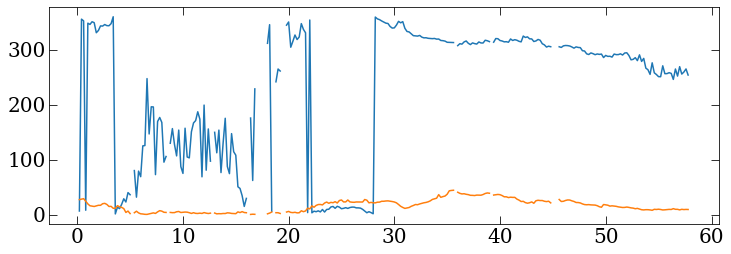

In [46]:
fig, axs = plt.subplots(figsize = (12,4))

axs.plot(plot_data[13]['time'] * 1e-3, theta, '-')
axs.plot(plot_data[13]['time'] * 1e-3, phi, '-')